In [41]:
# Core 
import datetime
import os
import glob
# from IPython.display import HTML, Image, display
import tempfile
import shutil
import sys
import pickle
import warnings

# Analysis 
import xarray as xr
import numpy as np
import pandas as pd

# Plotting 
# import cartopy.crs as ccrs
# from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
# import cartopy.feature as cfeature
# import matplotlib.pyplot as plt
# from matplotlib import rcParams
# import matplotlib.ticker as mticker
# from matplotlib.animation import FuncAnimation
# import matplotlib.colors as colors

# Debugging 
import pdb, traceback
%load_ext line_profiler

# Radar Tools
import pyart
import tint
from tint import animate
# from tint.visualization import embed_mp4_as_gif

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [2]:
# Store filenames for an example day of data
base = '/g/data/rr5/CPOL_radar/CPOL_level_1b/GRIDDED/GRID_70km_1000m/'

filenames = sorted(glob.glob(base + '2016/20161201/*.nc'))
# Generate grid generator 
# Note generators produce iterators
# These are alternative to using lists and looping
grids = (pyart.io.read_grid(fn, include_fields = 'reflectivity') 
         for fn in filenames)

# Define settings for tracking
settings = {
    'MIN_SIZE' : [15, 15, 15, 15],
    'FIELD_THRESH' : [47, 40, 35, 30],
    'ISO_THRESH' : [4, 4, 4, 4],
    'GS_ALT' : 3000,
    'LEVELS' : np.array(
        [[0, 2000], 
         [2000, 4000],
         [4000, 6000],
         [6000, 8000]]
    ),
    'TRACK_INTERVAL' : 1,
}

# Calculate high and low level tracks
tracks_obj  = tint.Cell_tracks()

for parameter in ['MIN_SIZE', 'FIELD_THRESH', 'GS_ALT', 'LEVELS', 
                  'TRACK_INTERVAL', 'ISO_THRESH'
                 ]:
    tracks_obj.params[parameter] = settings[parameter]

# Calculate tracks
tracks_obj.get_tracks(grids)

# Create directory for figures
dt=str(datetime.datetime.now())[0:-7]
dt=dt.replace(" ", "_")
dt=dt.replace(":", "_")
dt=dt.replace("-", "")  

out_file_name = '/g/data/w40/esh563/CPOL_analysis/TINT_tracks/tracks_obj_{}.pkl'.format(dt)

with open(out_file_name, 'wb') as f:
    pickle.dump(tracks_obj, f)
    
# if __name__ == '__main__':
#     try:
#         test()
#     except:
#         extype, value, tb = sys.exc_info()
#         traceback.print_exc()
#         pdb.post_mortem(tb)

No objects found in scan 143.    

Time elapsed: 0.2 minutes


In [39]:
filenames

['/g/data/rr5/CPOL_radar/CPOL_level_1b/GRIDDED/GRID_70km_1000m/2017/20170205/CPOL_20170205_1910_GRIDS_1000m.nc',
 '/g/data/rr5/CPOL_radar/CPOL_level_1b/GRIDDED/GRID_70km_1000m/2017/20170205/CPOL_20170205_1920_GRIDS_1000m.nc',
 '/g/data/rr5/CPOL_radar/CPOL_level_1b/GRIDDED/GRID_70km_1000m/2017/20170205/CPOL_20170205_1930_GRIDS_1000m.nc',
 '/g/data/rr5/CPOL_radar/CPOL_level_1b/GRIDDED/GRID_70km_1000m/2017/20170205/CPOL_20170205_1940_GRIDS_1000m.nc',
 '/g/data/rr5/CPOL_radar/CPOL_level_1b/GRIDDED/GRID_70km_1000m/2017/20170205/CPOL_20170205_1950_GRIDS_1000m.nc',
 '/g/data/rr5/CPOL_radar/CPOL_level_1b/GRIDDED/GRID_70km_1000m/2017/20170205/CPOL_20170205_2000_GRIDS_1000m.nc',
 '/g/data/rr5/CPOL_radar/CPOL_level_1b/GRIDDED/GRID_70km_1000m/2017/20170205/CPOL_20170205_2010_GRIDS_1000m.nc',
 '/g/data/rr5/CPOL_radar/CPOL_level_1b/GRIDDED/GRID_70km_1000m/2017/20170205/CPOL_20170205_2020_GRIDS_1000m.nc',
 '/g/data/rr5/CPOL_radar/CPOL_level_1b/GRIDDED/GRID_70km_1000m/2017/20170205/CPOL_20170205_2030_

In [44]:
base = '/g/data/rr5/CPOL_radar/CPOL_level_1b/GRIDDED/GRID_70km_1000m/'
filenames = sorted(glob.glob(base + '2017/20170205/*_19??*.nc'))

In [67]:
grids = (pyart.io.read_grid(fn, include_fields = 'reflectivity')
         for fn in filenames)
grids = list(grids)

In [65]:
# test2 = pyart.io.read('/g/data/rr5/CPOL_radar/CPOL_level_2_1km/STEINER_ECHO_CLASSIFICATION/CPOL_STEINER_ECHO_CLASSIFICATION_20170205.nc')
test = xr.open_dataset('/g/data/rr5/CPOL_radar/CPOL_level_2_1km/STEINER_ECHO_CLASSIFICATION/CPOL_STEINER_ECHO_CLASSIFICATION_20170205.nc')

In [117]:
test.time[125]

<xarray.DataArray 'time' ()>
array('2017-02-05T20:50:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2017-02-05T20:50:00

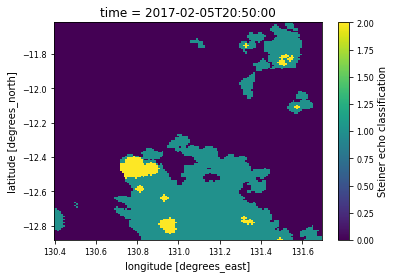

In [116]:
test.steiner_echo_classification[125,:,:].plot()

In [ ]:
# grid=grids[0]
grid.fields

In [2]:
with open('/g/data/w40/esh563/CPOL_analysis/TINT_tracks/tracks_obj_20190711_19_00_12.pkl', 'rb') as f:
    tracks_obj = pickle.load(f)

In [3]:
def file_names_from_object(tracks_obj, uid):
    base = '/g/data/rr5/CPOL_radar/CPOL_level_1b/GRIDDED/GRID_70km_1000m/'
    
    datetimes = tracks_obj.system_tracks.xs(uid, level='uid')
    datetimes = datetimes.reset_index(level='time')['time']
    filenames = []
    for i in range(len(datetimes)):
        year = str(datetimes.iloc[i])[0:4]
        month = str(datetimes.iloc[i])[5:7]
        day = str(datetimes.iloc[i])[8:10]
        hour = str(datetimes.iloc[i])[11:13]
        minute = str(datetimes.iloc[i])[14:16]
        filenames.append(base + '{0}/{0}{1}{2}/'.format(year, month, day) 
                         + 'CPOL_{0}{1}{2}'.format(year, month, day)
                         + '_{}{}_GRIDS_1000m.nc'.format(hour, minute))
    
    return sorted(filenames), datetimes.iloc[0], datetimes.iloc[-1]

In [4]:
lon_min = 130.40
lon_max = 131.69

lat_max = -11.61
lat_min = -12.87

# base = '/g/data/rr5/CPOL_radar/CPOL_level_1b/GRIDDED/GRID_70km_1000m/'

# # Note we only need grid generators for the grids that actually contain
# # the system!
# filenames = sorted(glob.glob(base + '2017/20171221/*_2[1-3]??_*.nc')
#                    + glob.glob(base + '2017/20161222/*_00??_*.nc'))

filenames, start_time, end_time = file_names_from_object(tracks_obj, '1362')

# Generate grid generator 
# Note generators produce iterators
# These are alternative to using lists and looping
grids = (pyart.io.read_grid(fn, include_fields = 'reflectivity')
         for fn in filenames)

# Create directory for figures
dt=str(datetime.datetime.now())[0:-7]
dt=dt.replace(" ", "_")
dt=dt.replace(":", "_")
dt=dt.replace("-", "")    

base_path = '/g/data/w40/esh563/CPOL_analysis/figures/TINT/'
out_path = base_path + dt + '_tint_CPOL_anim'

animate(tracks_obj, grids, out_path,
        start_datetime = start_time,
        end_datetime = end_time,
        lat_lines=np.arange(lat_min, lat_max, .1),
        lon_lines=np.arange(lon_min, lon_max, .1),
        tracers=True, keep_frames=False, dpi=100)

Animating from 2017-02-08 07:40:01 to 2017-02-08 10:30:01.
Plotting scan at 2017-02-08T10:30:01.000.
Creating GIF - may take a few minutes.


In [27]:
# Let's filter by tilt direction and magnitude
forward_tilt = ((-45 <= tracks_obj.system_tracks['sys_rel_tilt_dir'])
                & (tracks_obj.system_tracks['sys_rel_tilt_dir'] <= 45))
backward_tilt = ((-45 >= tracks_obj.system_tracks['sys_rel_tilt_dir'])
                | (tracks_obj.system_tracks['sys_rel_tilt_dir'] >= 45))
left_tilt = ((45 <= tracks_obj.system_tracks['sys_rel_tilt_dir'])
                & (tracks_obj.system_tracks['sys_rel_tilt_dir'] <= 135))
right_tilt = ((-135 <= tracks_obj.system_tracks['sys_rel_tilt_dir'])
                & (tracks_obj.system_tracks['sys_rel_tilt_dir'] <= -45))
sig_tilt_mag = (tracks_obj.system_tracks['tilt_mag'] >= 2)

In [36]:
# Let's find the cells that were tracked for the most frames
tracks_obj.system_tracks[forward_tilt & sig_tilt_mag].groupby(level='uid').size().sort_values(ascending=False)[:10]

uid
1256    10
48       8
1362     8
543      7
1233     7
1005     6
358      6
516      5
63       5
1444     5
dtype: int64

In [37]:
tracks_obj.system_tracks.xs('1256', level='uid')

,,grid_x,grid_y,lon,lat,u,v,n_cores,x_vert_disp,y_vert_disp,tilt_mag,vel_dir,tilt_dir,sys_rel_tilt_dir
scan,time,,,,,,,,,,,,,
9239,2017-02-05 19:10:01,6.054,56.853,130.4552,-12.3652,NaN,NaN,1,0.006,-0.664,0.664027,NaN,-89.482281,NaN
9240,2017-02-05 19:20:02,8.883,53.128,130.4828,-12.4012,4.715000,-6.208333,1,2.546,-0.705,2.641806,-52.784671,-15.477673,37.306997
9241,2017-02-05 19:30:02,7.622,53.317,130.4735,-12.4012,-2.101667,0.315000,1,1.420,-1.936,2.400936,171.475900,-53.741031,134.783069
9242,2017-02-05 19:40:02,9.152,51.396,130.4827,-12.4192,2.550000,-3.201667,1,3.316,-2.835,4.362692,-51.464074,-40.528646,10.935429
9243,2017-02-05 19:50:02,14.089,51.197,130.5288,-12.4193,8.228333,-0.331667,3,3.409,-6.360,7.216016,-2.308222,-61.808412,-59.500190
9244,2017-02-05 20:00:06,19.855,49.964,130.5840,-12.4284,9.610000,-2.055000,2,3.103,-5.048,5.925446,-12.070325,-58.421004,-46.350679
9245,2017-02-05 20:10:02,24.451,50.434,130.6208,-12.4284,7.660000,0.783333,1,1.285,-3.647,3.866760,5.838932,-70.590377,-76.429308
9246,2017-02-05 20:20:02,29.101,49.210,130.6669,-12.4375,7.750000,-2.040000,1,4.312,-1.135,4.458875,-14.747202,-14.746833,0.000369
9247,2017-02-05 20:30:02,34.198,48.159,130.7129,-12.4465,8.495000,-1.751667,1,3.682,-1.626,4.025047,-11.651078,-23.826628,-12.175551


In [38]:
uid = '1256'

filenames, start_time, end_time = file_names_from_object(tracks_obj, uid)

grids = (pyart.io.read_grid(fn) for fn in filenames)  # refresh grid generator

# Create directory for figures
dt=str(datetime.datetime.now())[0:-7]
dt=dt.replace(" ", "_")
dt=dt.replace(":", "_")
dt=dt.replace("-", "")

base_path = '/g/data/w40/esh563/CPOL_analysis/figures/TINT/'
out_path = base_path + dt + '_tint_CPOL_lagrangian'
animate(tracks_obj, grids, out_path, style='lagrangian', uid=uid, alt=6000,
        keep_frames=False, dpi=100)

Animating 15 frames
Plotting frame at 2017-02-05 21:30:01.000
Creating GIF - may take a few minutes.
